# Learning from networks - Stonks

Start by importing the libraries we will use throughout the notebook.

In [1]:
import networkx as nx
import extended_networkx as ex
import matplotlib.pyplot as plt
from node2vec import Node2Vec
import igraph

## Load graph and compute market capitalization

First of all let's start by loading the graph file, then we compute what we called "market capitalization" which is how much an node has been bought.
Note: we compute the longest path which in this specific case indicates how long is the path of ETF buying other ETF's

In [3]:
# Load Graph
G = nx.read_gml("out_graph.gml")
G_undirected = G.to_undirected() # Needed to compute the number of connected components

print(f"The graph contains {len(G.nodes())} nodes and {len(G.edges())} edges.")
print(f"There are {nx.number_connected_components(G_undirected)} connected components.")
print(f"Sizes: {[len(c) for c in sorted(nx.connected_components(G_undirected), key=len, reverse=True)]}")
print(f"Longest path: {ex.longest_path(G) - 2}") # -2 because the last two nodes are an ETF not buying an ETF and a component node

#print(f"The diameter of the graph is {nx.diameter(G)}.")


def compute_capitalization(G: nx.Graph):
    """
    Adds the 'capitalization' attribute to every node, which is the sum of the incoming edges weights.
    """
    for node in G.nodes():
        capitalization = 0
        for edge in G.in_edges(node):
            capitalization += G.get_edge_data(*edge)["weight"]
        G.nodes[node]["capitalization"] = capitalization

compute_capitalization(G)

The graph contains 25396 nodes and 396114 edges.
There are 6 connected components.
Sizes: [25189, 125, 38, 18, 13, 13]
Longest path: 7


Now let's print the top 20 capitalization nodes.

In [3]:
k = 20
print(f"Top {k} nodes with highest capitalization: {ex.max_k_nodes(G, k, 'capitalization')}")

Top 20 nodes with highest capitalization: ['CPIN', 'AAPL', 'MSFT', 'AMZN', 'ADRO', 'GOOGL', 'FB', 'GOOG', 'TSLA', 'NVDA', 'JPM', 'UNVR', 'JNJ', 'V', 'UNH', 'HD', 'PG', 'BAC', 'MA', 'PYPL']


## Node-level features

### Betweenness centrality

We try to compute betweenness centralities of the nodes. The graph is too big to compute the exact betweenness centrality of each node, so we only use a small percentage of the nodes.

In [4]:
b_centralities = ex.betweenness_centrality_percent(G, percentage=0.02)
print(sorted(b_centralities.items(), key=lambda t: t[1], reverse=True)[:k])

[('FM', 9.814004062132403e-05), ('SMIN', 7.2578851334021e-05), ('EDEN', 5.6253274234466155e-05), ('IGM', 4.813713019068745e-05), ('HART', 4.1886766386857884e-05), ('JKH', 4.1793477374860424e-05), ('HYG', 3.227799815111988e-05), ('ASHR', 2.7053813479262328e-05), ('FYC', 2.425514311933864e-05), ('FXR', 2.266922991538188e-05), ('LQD', 2.1643050783409863e-05), ('THD', 2.1083316711425126e-05), ('FXD', 1.996384856745565e-05), ('BMED', 1.7538334255521787e-05), ('FTC', 1.595242105156503e-05), ('BFIT', 1.5765843027570114e-05), ('FXL', 1.539268697958029e-05), ('VOE', 1.0541658355712563e-05), ('AIA', 8.862456139758349e-06), ('VNM', 6.716808863816854e-06)]


### Clustering coefficients

The computation for the exact clustering coefficient is doable ...

In [ ]:
nodes_clustering_coeff = nx.clustering(G, weight="weight")
# Print top k nodes with highest clustering coefficient
print(f"Top {k} nodes by clustering coefficient:") 
print(sorted(nodes_clustering_coeff.items(), key=lambda t: t[1], reverse=True)[:k])
print(f"\nGlobal clustering coefficient: {nx.transitivity(G)}")


Top 20 nodes by clustering coefficient
[('RWVG', 2.220278602733271e-05), ('UNA', 1.9880340687835784e-05), ('SSI', 1.5219529225139582e-05), ('HPG', 1.2501223578956097e-05), ('PDR', 1.2427193087025836e-05), ('CRHl', 1.2137344349100606e-05), ('VIC', 1.1967758246053812e-05), ('KRZ', 1.1909451311225256e-05), ('BCM', 1.1672895376409549e-05), ('RWGV', 1.1043518322844037e-05), ('VHM', 1.0180368464746611e-05), ('VCI', 8.455830606685144e-06), ('NVL', 8.304115970363736e-06), ('HSG', 8.276992510958094e-06), ('GEX', 7.798399073501852e-06), ('EXK', 7.639429907146357e-06), ('VCB', 7.093919710666592e-06), ('NOVO', 6.784985924541269e-06), ('JETl', 6.676593093953429e-06), ('DGC', 6.654628072496844e-06)]
Global clustering coefficient: 9.24110477412097e-05


## Cycles

Since the graph has more than one connected component, in order to compute closeness centrality for all the nodes, we use an algotithm found on the internet which basically computes the shortest paths using the Floyd — Warshall Method and uses the shortest path Matrix to calculate the closeness metric for each node. It returnes for each node the quantity $$c(v) = \frac{(n_v - 1)^2}{(n - 1) \sum_{u \in C_v}d(v, u)}$$ 
While `ex.closeness_centrality_matrix(G)` takes approximately two minutes to be executed, `nx.closeness_centrality(G, wf_improved=True)` takes more than 30 minutes.

In [ ]:
cycle = list(nx.find_cycle(G, orientation="original"))
if cycle:
    print(f"There is actually a cycle in the graph: {cycle}")
else:
    print("There is no cycle in the graph.")

There is actually a cycle in the graph: [('BFIT', 'BFIT', 'forward')]


## Embeddings

Let's try some embeddings now

### Node2Vec

Computing transition probabilities:  40%|███▉      | 9260/23155 [00:00<00:01, 12829.29it/s]/home/luca/Projects/LFN-stonks/.venv/lib/python3.9/site-packages/node2vec/node2vec.py:132: RuntimeWarning: invalid value encountered in true_divide
  d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()
Generating walks (CPU: 2): 100%|██████████| 150/150 [00:18<00:00,  8.17it/s]


TypeError: 'Word2Vec' object is not subscriptable

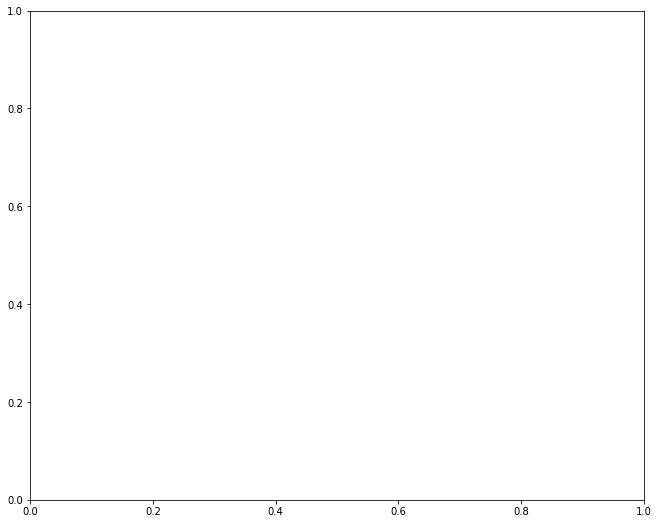

In [8]:
node2vec = Node2Vec(G, dimensions=2, walk_length=5, num_walks=300, workers=2)
model = node2vec.fit(window=10, min_count=1)
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(model[:, 0], model[:, 1])

As an approximation we compute the closeness centrality of the nodes in a small random connected subgraph.
We devised our own algorithm to draw a connected sample of `k` nodes from the graph `G`: `connected_random_subgraph(G, n)`.

In [5]:
sub_G = ex.connected_random_subgraph(G, 8000)
c_centralities = nx.closeness_centrality(sub_G)
print(sorted(c_centralities.items(), key=lambda t: t[1], reverse=True)[:k])

There are 1 components with more than 8000 nodes.
[('T', 0.018846105763220405), ('MSFT', 0.01744407504063008), ('AAPL', 0.017162859643169683), ('AMZN', 0.017076841636454558), ('INTC', 0.016514665139594063), ('MRK', 0.015457018707425007), ('JNJ', 0.015295321957085639), ('CMCSA', 0.015253400698991757), ('ABBV', 0.014991500493578296), ('PEP', 0.014848838863478625), ('FB', 0.014762400855662513), ('CSCO', 0.014555932045618258), ('KEY', 0.014535572220789201), ('AVGO', 0.014474498387928742), ('NVDA', 0.014453348518785112), ('ADM', 0.01438198207955718), ('GOOGL', 0.014236576869405972), ('PFE', 0.014212851167799483), ('EBAY', 0.014058063564251837), ('ADBE', 0.013932545139571019)]


In [9]:
igraph_sub_G = igraph.Graph.from_networkx(sub_G)
print(ex.enumerate_subgraphs(igraph_sub_G, 3))

NameError: name 'G' is not defined